This notebook explores some basic image properties and image transformation methods of the nuclei imaging dataset.
<br>Data Source: https://www.kaggle.com/c/data-science-bowl-2018

In [1]:
# load necessary libraries, classes
import matplotlib.pyplot as plt
import os
import numpy as np
import cv2
from PIL import Image
from LoadImage import LoadImage


First let's take a look at a few images and their corresponding masks:

reading file locations


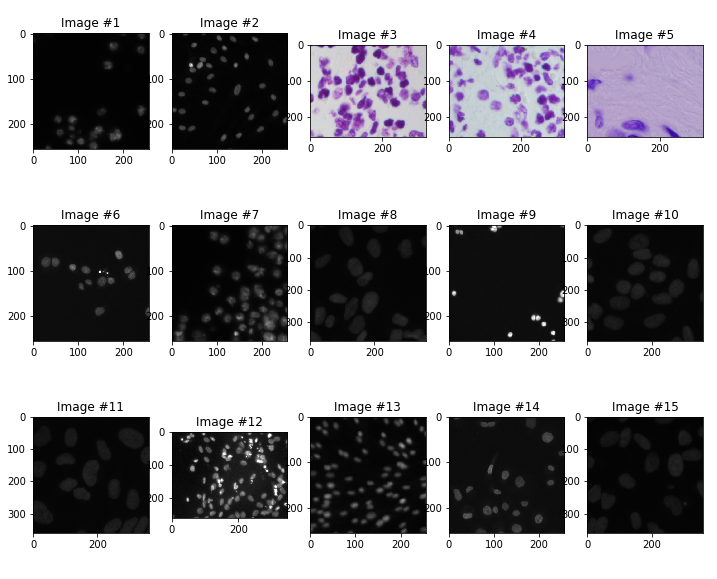

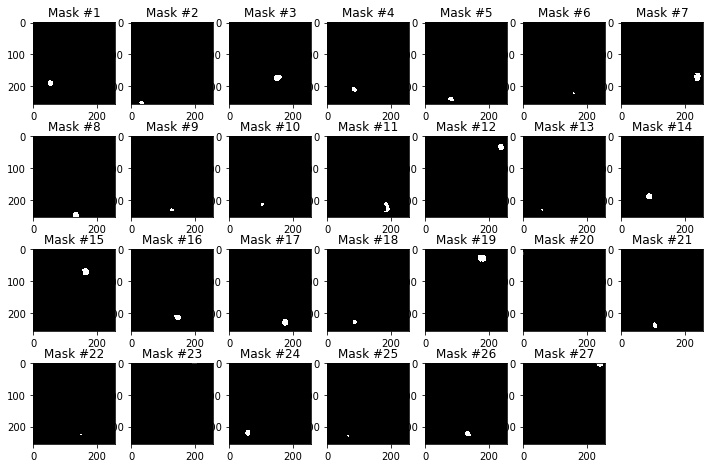

In [25]:
pathname = 'data/stage1_train'
im = LoadImage(pathname, image_type='train')
list_images = np.array(list(im.dict_files.keys()))

# display images
n_img = 15
fig_img, axes = plt.subplots()
fig_img.set_size_inches(12, 10)
plt.axis('off')
for n in range(n_img):
    ax = fig_img.add_subplot(3,5,n+1)
    path = pathname + '/' + list_images[n] + '/images/' + list_images[n] + '.png'
    im_array = Image.open(path)
    ax.imshow(im_array)
    ax.set_title('Image #' + str(n+1))

# display masks of image # 1
maskpath = im.dict_files[list_images[0]]['masks']
n_mask = len(maskpath)
fig_mask, axes = plt.subplots()
fig_mask.set_size_inches(12, 8)
plt.axis('off')
for nm in range(n_mask):
    ax_m = fig_mask.add_subplot(4,7,nm+1)
    path = pathname + '/' + list_images[0] + '/masks/' + maskpath[nm]
    mask_array = im.load_image(path)
    ax_m.imshow(mask_array, cmap='gray')
    ax_m.set_title('Mask #'+str(nm+1))
plt.show()

From the above results, we can see that the images are of different shapes and colors (gray scale, rgb). For one given image, each mask image dipicts a single nucleus in an image of the same size as the original image.
<br>
To get a sense of the quantity of masks, we plot the histogram of mask numbers across the whole training dataset. The majority of mask counts falls around 30.


Training Images: total = 670


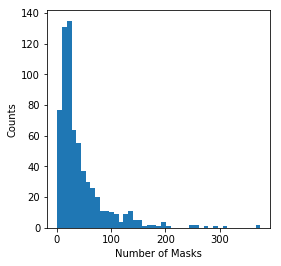

In [22]:
print('Training Images: total =', list_images.shape[0])
# histogram of count of training masks
n_masks = np.array([len(im.dict_files[list_images[n]]['masks']) for n in range(len(list_images))])
plt.rcParams['figure.figsize'] = [4, 4]
plt.hist(n_masks, bins='auto')
plt.ylabel('Counts')
plt.xlabel('Number of Masks')
plt.show()

Now we explore the distribution of image sizes, which would be later useful when we apply the convolutional neural networks that take inputs with the same size. 

In [4]:
# explore image sizes
sizes = []
for n in range(len(list_images)):
    path = pathname + '/' + list_images[n] + '/images/' + list_images[n] + '.png'
    im_array = im.load_image(path)
    sizes.append(im_array.shape)
    if n == 10:
        im0 = im_array
sizes = np.array(sizes)
unique, unique_counts = np.unique(sizes,  return_counts=True, axis=0)
print('Image sizes distribution:')
for n in range(len(unique)):
    print(unique[n],':', unique_counts[n])


Image sizes distribution:
[256 256] : 334
[256 320] : 112
[260 347] : 5
[360 360] : 91
[512 640] : 13
[520 696] : 92
[ 603 1272] : 6
[1024 1024] : 16
[1040 1388] : 1


The majority of image sizes are 256 by 256 pixel. 
<br>
To get image data ready to feed a convolutional neural network, we need to transform the images by:
<br>1.normalizing, resizing
<br>2.stacking the masks together and label each pixel by one of the categories (nucleus contour, nucleus inner area, background).


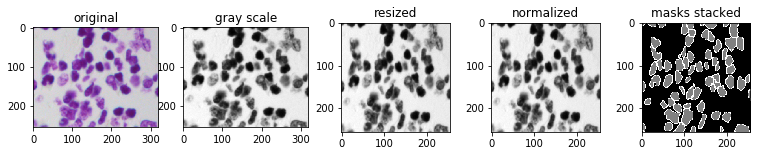

In [17]:
img_id = 2
path0 = pathname + '/' + list_images[img_id] + '/images/' + list_images[img_id] + '.png'
img0 = np.asarray(Image.open(path0).convert('RGB'))
img_gray = np.asarray(Image.open(path0).convert('L'))
img_resize = cv2.resize(img_gray, (256, 256))
img_norm = np.divide(img_resize, np.max(img_resize))

fig_mask_stack, axes = plt.subplots(1,5)
fig_mask_stack.set_size_inches(13, 2)
axes[0].imshow(img0)
axes[1].imshow(img_gray, cmap='gray')
axes[2].imshow(img_resize, cmap='gray')
axes[3].imshow(img_norm, cmap='gray')
axes[0].set_title('original')
axes[1].set_title('gray scale')
axes[2].set_title('resized')
axes[3].set_title('normalized')

# stack masks

def pad(im_array):
    # pad zero arround image array
    new_array = np.zeros((im_array.shape[0]+2, im_array.shape[1]+2))
    new_array[1:im_array.shape[0]+1, 1:im_array.shape[0]+1] = im_array
        
    return new_array 


def find_contour(im_array):

    im = pad(im_array)
    im1 = np.multiply(im[0:-2, 0:-2], im[2:, 2:])
    im2 = np.multiply(im[0:-2, 2:], im[2:, 0:-2])
    im = np.multiply(im1, im2)
    #label pixels by 0=outer, 1=inner, 2=contour
    contour = im_array - im
    im[contour!=0] = 2

    return im


maskpath = im.dict_files[list_images[img_id]]['masks']
mask_stack = np.zeros((256, 256))
for m in maskpath:
    mp = pathname + '/' + list_images[img_id] + '/masks/' + m
    msk = np.asarray(Image.open(mp).convert('L'))
    msk = np.divide(msk, np.max(msk))
    msk = cv2.resize(msk, (256, 256))    
    msk = find_contour(msk)
    mask_stack = np.maximum(mask_stack, msk)

axes[4].imshow(mask_stack, cmap='gray')
axes[4].set_title('masks stacked')

plt.show()